In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch

In [ ]:
sudoku1 = pd.read_csv("sudoku1.csv", delimiter="\t", header=None)
sudoku2 = pd.read_csv("sudoku2.csv", delimiter="\t", header=None)

# Select only EEG channels (columns 1 to 8)
eeg_channels = list(range(1, 9))
sudoku1_eeg = sudoku1.iloc[:, eeg_channels]
sudoku2_eeg = sudoku2.iloc[:, eeg_channels]

sudoku1_eeg = sudoku1_eeg.apply(pd.to_numeric)
sudoku2_eeg = sudoku2_eeg.apply(pd.to_numeric)

print(sudoku1_eeg.head())
print(sudoku2_eeg.head())

             1             2             3             4             5  \
0     0.000000      0.000000      0.000000      0.000000      0.000000   
1  8913.562764  17400.631893  23271.362277  20163.173397  24611.349358   
2  8040.235405  16512.999417  22380.265281  19266.846093  23718.508925   
3  6743.811875  15223.259058  21090.748440  17974.468228  22431.271962   
4  7412.531365  15905.166078  21768.945070  18651.234347  23118.118717   

              6             7             8  
0      0.000000      0.000000      0.000000  
1  11486.784993  19364.746733  14552.572614  
2  10587.261389  18475.370821  13660.022755  
3   9301.432586  17191.084288  12371.064707  
4   9999.812841  17878.579244  13050.982422  
              1             2             3             4             5  \
0      0.000000      0.000000      0.000000      0.000000      0.000000   
1  42721.783247  52654.205579  55896.057891  53493.692397  57934.358172   
2  41551.356501  51484.672902  54724.535909  52322.729

In [ ]:
# Sampling rate
fs = 250  # Hz (samples per second)

# Extract timestamp column (column 22 based on Cassia's email)
sudoku1_timestamps = sudoku1.iloc[:, 22]
sudoku2_timestamps = sudoku2.iloc[:, 22]

# Verify timestamp consistency
sudoku1_time_diff = np.diff(sudoku1_timestamps)
sudoku2_time_diff = np.diff(sudoku2_timestamps)

if not np.isclose(np.mean(sudoku1_time_diff), 1/fs, atol=1e-4):
    sudoku1_time_fixed = np.arange(len(sudoku1_eeg)) / fs
else:
    sudoku1_time_fixed = sudoku1_timestamps - sudoku1_timestamps.iloc[0]

if not np.isclose(np.mean(sudoku2_time_diff), 1/fs, atol=1e-4):
    sudoku2_time_fixed = np.arange(len(sudoku2_eeg)) / fs
else:
    sudoku2_time_fixed = sudoku2_timestamps - sudoku2_timestamps.iloc[0]

In [ ]:
# Bandpass filter function
def bandpass_filter(data, lowcut=0.1, highcut=30, fs=250, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

sudoku1_filtered = bandpass_filter(sudoku1_eeg, lowcut=0.1, highcut=30, fs=250)
sudoku2_filtered = bandpass_filter(sudoku2_eeg, lowcut=0.1, highcut=30, fs=250)

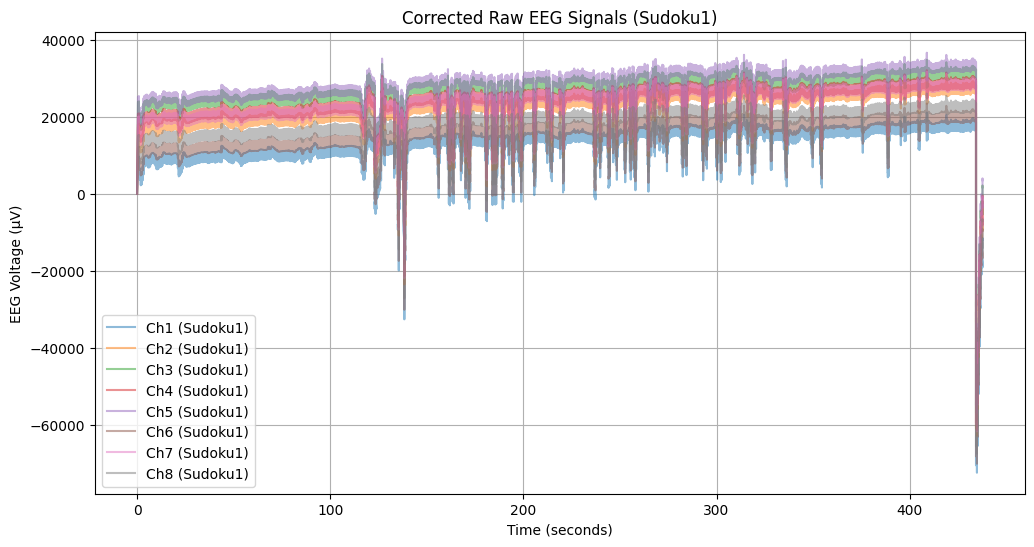

In [5]:
# Raw EEG signals for sudoku1
plt.figure(figsize=(12, 6))
for i in range(8):
    plt.plot(sudoku1_time_fixed, sudoku1_eeg.iloc[:, i], label=f"Ch{i+1} (Sudoku1)", alpha=0.5)
plt.xlabel("Time (seconds)")
plt.ylabel("EEG Voltage (µV)")
plt.title("Corrected Raw EEG Signals (Sudoku1)")
plt.legend()
plt.grid()
plt.show()

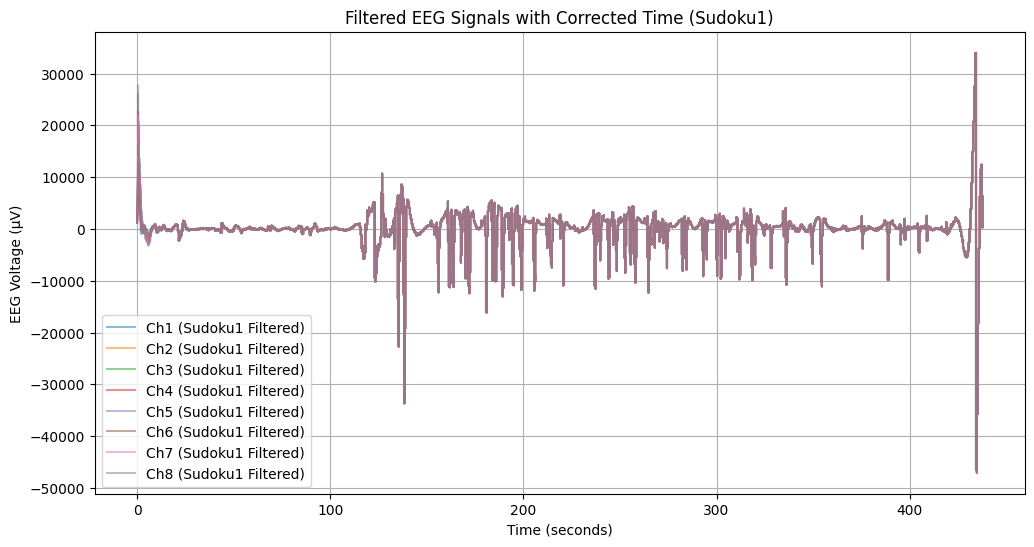

In [6]:
# Filtered EEG signals for sudoku1
plt.figure(figsize=(12, 6))
for i in range(8):
    plt.plot(sudoku1_time_fixed, sudoku1_filtered[:, i], label=f"Ch{i+1} (Sudoku1 Filtered)", alpha=0.5)
plt.xlabel("Time (seconds)")
plt.ylabel("EEG Voltage (µV)")
plt.title("Filtered EEG Signals with Corrected Time (Sudoku1)")
plt.legend()
plt.grid()
plt.show()

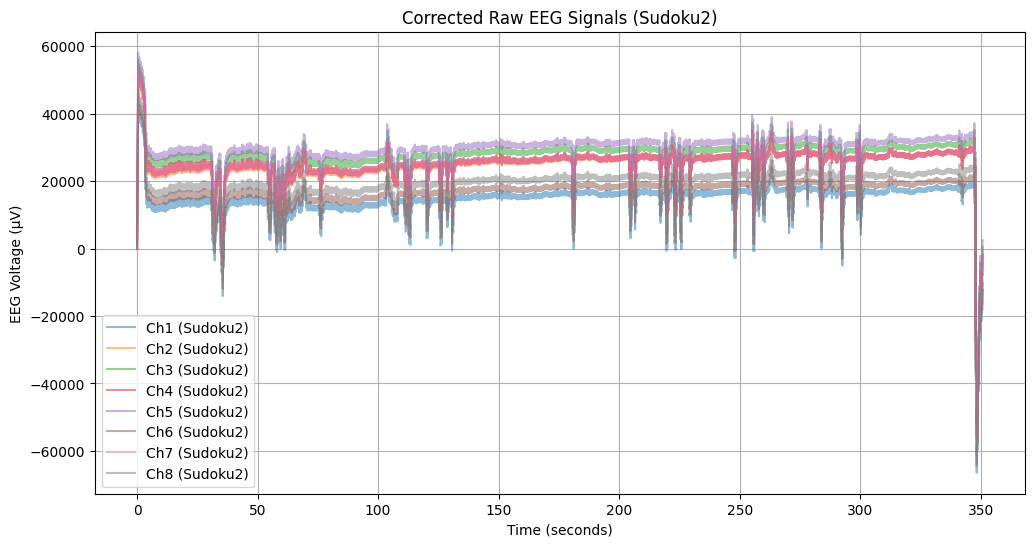

In [7]:
# Raw EEG Signals for Sudoku2
plt.figure(figsize=(12, 6))
for i in range(8):
    plt.plot(sudoku2_time_fixed, sudoku2_eeg.iloc[:, i], label=f"Ch{i+1} (Sudoku2)", alpha=0.5)
plt.xlabel("Time (seconds)")
plt.ylabel("EEG Voltage (µV)")
plt.title("Corrected Raw EEG Signals (Sudoku2)")
plt.legend()
plt.grid()
plt.show()

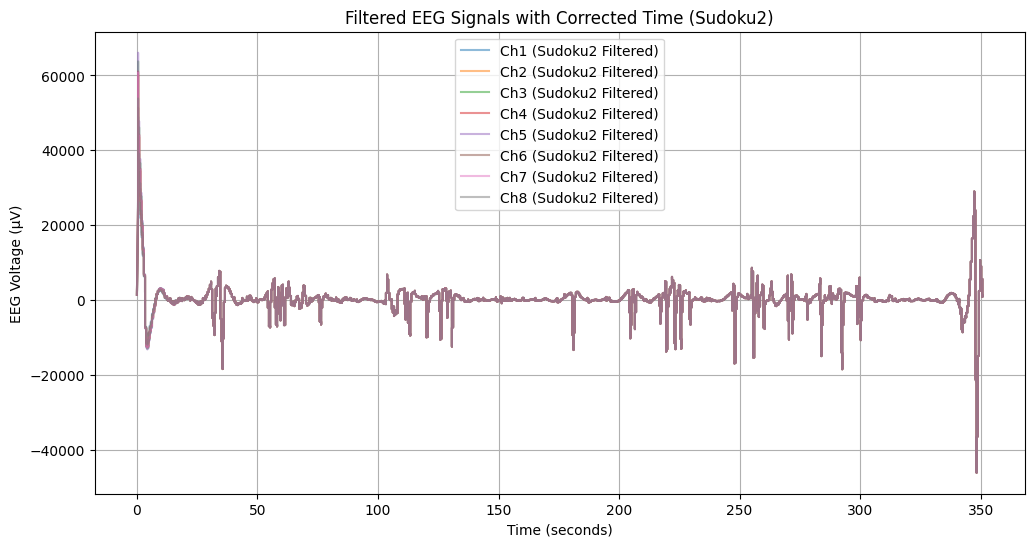

In [8]:
# Filtered EEG Signals for Sudoku2
plt.figure(figsize=(12, 6))
for i in range(8):
    plt.plot(sudoku2_time_fixed, sudoku2_filtered[:, i], label=f"Ch{i+1} (Sudoku2 Filtered)", alpha=0.5)
plt.xlabel("Time (seconds)")
plt.ylabel("EEG Voltage (µV)")
plt.title("Filtered EEG Signals with Corrected Time (Sudoku2)")
plt.legend()
plt.grid()
plt.show()

In [9]:
# Compute and Plot EEG Power Changes Between Sudoku1 and Sudoku2
bands = {"Delta": (0.5, 4), "Theta": (4, 8), "Alpha": (8, 12), "Beta": (12, 30)}
psd_values = {}
for band, (low, high) in bands.items():
    psd_values[band] = {}
    for i in range(8):
        freqs, psd1 = welch(sudoku1_filtered[:, i], fs=250, nperseg=250*2)
        freqs, psd2 = welch(sudoku2_filtered[:, i], fs=250, nperseg=250*2)
        band_idx = np.where((freqs >= low) & (freqs <= high))
        psd_values[band][f"Ch{i+1}"] = np.mean(psd2[band_idx]) - np.mean(psd1[band_idx])

psd_df = pd.DataFrame(psd_values)

<Figure size 800x500 with 0 Axes>

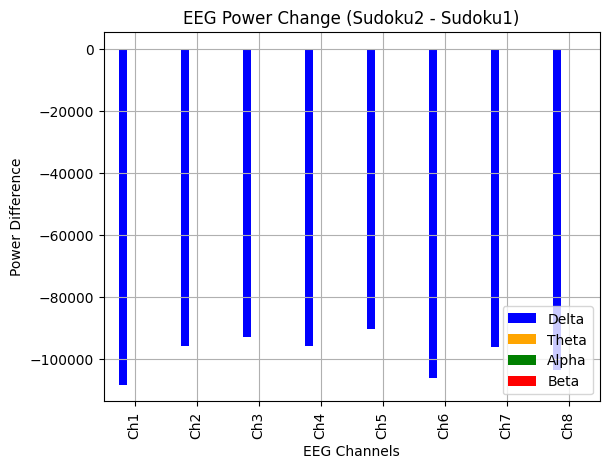

In [10]:
# EEG Power Differences Between Sudoku1 and Sudoku2
plt.figure(figsize=(8, 5))
psd_df.plot(kind='bar', color=['blue', 'orange', 'green', 'red'])
plt.xlabel("EEG Channels")
plt.ylabel("Power Difference")
plt.title("EEG Power Change (Sudoku2 - Sudoku1)")
plt.legend(["Delta", "Theta", "Alpha", "Beta"])
plt.grid()
plt.show()